In this Radar Plot plotting we are using four classifiers (Linear, ANN,knn, Protonet) and two evaluation metrics AUC and Balanced accuracy.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import os
import sys
# aggregation method one
EVAL_METRIC = "AUC"  # BalAcc or AUC
AGG1 = r"Averaging"   # Averaging or Clustering
AGG2 = r"Clustering\\cluster_2" # Clustering\cluster_2 or Clustering\cluster_3 
# split AGG2 last name and use as AGG2_DIR
AGG2_DIR = AGG2.split("\\")[-1]  # cluster_2 or cluster_3
INPUT_DIR = r"E:\KSA Project\KSAproject_pipeline1\WSI_Classification"
OUTPUT_DIR = r"E:\KSA Project\KSAproject_pipeline1\Analysis_Visualization"

### Dataset Reshaping for Radar Plots

In [ ]:
# === CONFIG ===
sheet_list = ["baseline", "uni", "conch", "virchow2"]
sheet_map = {
    "TCGA-CV": "(CV)",
    "PAIP-EV47": "(EV-47)",
    "PAIP-EV78": "(EV-78)",
    "PAIP-IV": "(IV)"
}
# metric names just rewritten for better readability e.g. "lin_acc" -> "Lin_Acc"
metric_rename_map = {
    "lin_acc": "Lin_Acc", "lin_bacc": "Lin_BalAcc", "lin_auroc": "Lin_AUC",
    "lin_macro_f1": "Lin_MacroF1", "lin_weighted_f1": "Lin_WF1", "lin_conf_matrix": "Lin_CM",
    "ann_acc": "ANN_Acc", "ann_bacc": "ANN_BalAcc", "ann_auroc": "ANN_AUC",
    "ann_macro_f1": "ANN_MacroF1", "ann_weighted_f1": "ANN_WF1", "ann_conf_matrix": "ANN_CM",
    "knn_acc": "KNN_Acc", "knn_bacc": "KNN_BalAcc", "knn_auroc": "KNN_AUC",
    "knn_macro_f1": "KNN_MacroF1", "knn_weighted_f1": "KNN_WF1", "knn_conf_matrix": "KNN_CM",
    "proto_acc": "Proto_Acc", "proto_bacc": "Proto_BalAcc", "proto_auroc": "Proto_AUC",
    "proto_macro_f1": "Proto_MacroF1", "proto_weighted_f1": "Proto_WF1", "proto_conf_matrix": "Proto_CM"
}

def consolidate_all_eval_metrics(input_dir, sheet_names, output_excel_path):
    """
    Traverses folders under input_dir, finds Excel files with 'eval_metrics',
    extracts Metric & AvgFolds columns from specified sheets, and writes to one summary Excel.
    Each sheet in the final Excel corresponds to one experiment folder.
    """
    all_combined_sheets = {}

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if "eval_metrics" in file and file.endswith(".xlsx"):
                file_path = os.path.join(root, file)
                exp_name = os.path.basename(root)  # Folder name as sheet name

                print(f"\n📘 Processing file: {file_path}")
                print(f"📝 Using sheet name: {exp_name}")

                try:
                    combined_df = pd.DataFrame()

                    for sheet in sheet_names:
                        df = pd.read_excel(file_path, sheet_name=sheet)

                        if "Metric" not in df.columns or "AvgFolds" not in df.columns:
                            print(f"[WARNING] Sheet '{sheet}' missing required columns in file {file}")
                            continue

                        temp_df = df[["Metric", "AvgFolds"]].copy()
                        temp_df.rename(columns={"AvgFolds": f"{sheet}_N"}, inplace=True)

                        if combined_df.empty:
                            combined_df = temp_df
                        else:
                            combined_df = pd.merge(combined_df, temp_df, on="Metric", how="outer")

                    all_combined_sheets[exp_name] = combined_df

                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    # ✅ Write all collected sheets into a single Excel file
    with pd.ExcelWriter(output_excel_path, engine="openpyxl", mode="w") as writer:
        for sheet_name, df in all_combined_sheets.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"\n✅ All consolidated metrics saved to '{output_excel_path}'")

def merge_all_exp_metrics(input_excel, output_excel, sheet_map, metric_rename_map):
    # === LOAD & MERGE ===
    final_df = pd.DataFrame()
    for sheet, suffix in sheet_map.items():
        df = pd.read_excel(input_excel, sheet_name=sheet)
        # Rename metrics
        df['Metric'] = df['Metric'].apply(
            lambda m: f"{metric_rename_map.get(m.strip().lower(), m)} {suffix}"
        )
        # Extract only relevant columns
        temp = df[["Metric", "baseline_N", "conch_N", "uni_N", "virchow2_N"]]
        final_df = pd.concat([final_df, temp], axis=0)

    # Save the final output
    final_df.to_excel(output_excel, index=False, sheet_name="Merged_Metrics")
    print(f"✅ Merged output saved to:\n{output_excel}")

cons_output_file_agg1 = f"{INPUT_DIR}/{AGG1}/all_exp_{AGG1}_metrics.xlsx"
cons_output_file_agg2 = f"{INPUT_DIR}/{AGG2}/all_exp_{AGG2_DIR}_metrics.xlsx"
# check if the consolidated files not already exist then generate them
if not os.path.exists(cons_output_file_agg1):
    consolidate_all_eval_metrics(f"{INPUT_DIR}/{AGG1}", sheet_list, f"{INPUT_DIR}/{AGG1}/all_exp_{AGG1}_metrics.xlsx")
if not os.path.exists(cons_output_file_agg2):
    consolidate_all_eval_metrics(f"{INPUT_DIR}/{AGG2}", sheet_list, f"{INPUT_DIR}/{AGG2}/all_exp_{AGG2_DIR}_metrics.xlsx")

merge_metrics_file_agg1 = f"{INPUT_DIR}/{AGG1}/all_exp_{AGG1}_merged_metrics.xlsx"
merge_metrics_file_agg2 = f"{INPUT_DIR}/{AGG2}/all_exp_{AGG2_DIR}_merged_metrics.xlsx"
# check if the merged files not already exist then generate them
if not os.path.exists(merge_metrics_file_agg1):
    merge_all_exp_metrics(cons_output_file_agg1, merge_metrics_file_agg1, sheet_map, metric_rename_map)
if not os.path.exists(merge_metrics_file_agg2):
    merge_all_exp_metrics(cons_output_file_agg2, merge_metrics_file_agg2, sheet_map, metric_rename_map)

### Data Loading for Radar Plots

In [27]:
colors = ["r", "g", "b", "brown"]  # Choose 4 distinct colors
experiment_colors = {
    "TCGA-CV": "#00f0f0",
    "PAIP 47-EV": "#ff9999",  # Light red
    "PAIP 78-EV": "#99ccff",  # Light blue
    "PAIP 47/31-IV": "#99ff99"  # Light green
}
# ----------------------------
# Settings
# ----------------------------
avg_file_path = f"{INPUT_DIR}/{AGG1}/all_exp_{AGG1}_merged_metrics.xlsx"
clustering_file_path = f"{INPUT_DIR}/{AGG2}/all_exp_{AGG2_DIR}_merged_metrics.xlsx"
# Names of the sheets corresponding to the aggregation methods
aggregation_methods = ["Average", "Cluster"]

# Experiments and mapping for suffixes
experiments = ["TCGA-CV", "PAIP 47-EV", "PAIP 78-EV", "PAIP 47/31-IV"]
experiment_mapping = {
    "TCGA-CV": "CV",
    "PAIP 47-EV": "EV-47",
    "PAIP 78-EV": "EV-78",
    "PAIP 47/31-IV": "IV"
}

# Classifier models and how they should appear in labels
classifier_models = ["Lin", "ANN", "Proto"]
classifier_label_mapping = {
    "Lin": "Linear",
    "ANN": "ANN",
    "Proto": "Proto"
}

# Evaluation metrics to use (ignoring Accuracy and MacroF1 as per your instruction)
eval_metric = [EVAL_METRIC]

# Foundational models and mapping to Excel columns
foundation_models = ["BASELINE", "CONCH", "UNI", "VIRCHOW2"]
model_mapping = {
    "BASELINE": "baseline_N",
    "CONCH": "conch_N",
    "UNI": "uni_N",
    "VIRCHOW2": "virchow2_N"
}

# ----------------------------
# Generate axis labels programmatically
# ----------------------------
# For each aggregation method, for each experiment, for each classifier and for each metric,
# we generate an axis label.
# For TCGA-CV we omit the suffix, for others we include it.
axis_labels = []
for agg in aggregation_methods:
    for exp in experiments:
        exp_suffix = experiment_mapping[exp]
        for clf in classifier_models:
            full_clf = classifier_label_mapping[clf]
            for metric in eval_metric:
                label = f"{full_clf}-{metric} ({exp_suffix})"
                axis_labels.append(label)

# ----------------------------
# Generate experiment_groups (if needed for color coding, etc.)
# ----------------------------
experiment_groups = []
for agg in aggregation_methods:
    for exp in experiments:
        # Each experiment repeats for len(classifier_models) * len(eval_metric) times:
        experiment_groups.extend([exp] * (len(classifier_models) * len(eval_metric)))

# ----------------------------
# Function to extract values from a given sheet DataFrame
# ----------------------------
def extract_values(df, target_metrics):
    """
    Given a DataFrame (from one sheet) and a list of target metrics (e.g., ["BalAcc", "WF1", "AUC"]),
    extract values for each experiment and each classifier model.
    Returns a dictionary: {foundation_model: [values,...]}
    """
    # Ensure the Metric column and headers are stripped of whitespace.
    df['Metric'] = df['Metric'].astype(str).str.strip()
    df.columns = df.columns.str.strip()
    
    # Initialize the dictionary
    data = {fm: [] for fm in foundation_models}
    
    for exp in experiments:
        exp_suffix = experiment_mapping[exp]
        for clf in classifier_models:
            for metric in target_metrics:
                # Construct the expected metric name.
                # We assume the Excel file uses underscore "_" as in "ANN_BalAcc (CV)".
                metric_name = f"{clf}_{metric} ({exp_suffix})"
                # Filter rows that exactly match this metric_name.
                row = df[df['Metric'] == metric_name]
                if row.empty:
                    # If not found, append 0.0 for each foundational model.
                    for fm in foundation_models:
                        data[fm].append(0.0)
                else:
                    for fm in foundation_models:
                        col_name = model_mapping[fm]
                        # This uses .iloc[0] on the filtered row.
                        value = row[col_name].iloc[0]
                        data[fm].append(round(value, 4))  # Round to 4 decimal places
    return data

# ----------------------------
# Read data from both sheets and combine results
# ----------------------------
avg_df = pd.read_excel(avg_file_path)
cluster_df = pd.read_excel(clustering_file_path)

# Use our extraction function for each sheet
avg_data = extract_values(avg_df, eval_metric)
cluster_data = extract_values(cluster_df, eval_metric)

# Combine the results: concatenate the lists for each foundational model.and round to 4 decimal places
models_data = {
    fm: avg_data[fm] + cluster_data[fm]
    for fm in foundation_models
}

# For debugging, print the dictionaries:
print("axis_labels =", axis_labels)
print("experiment_groups =", experiment_groups)
print("model_data =", models_data)
# print the length of each list inside the model_data dictionary
for k, v in models_data.items():
    print(f"{k}: {len(v)} values")

axis_labels = ['Linear-AUC (CV)', 'ANN-AUC (CV)', 'Proto-AUC (CV)', 'Linear-AUC (EV-47)', 'ANN-AUC (EV-47)', 'Proto-AUC (EV-47)', 'Linear-AUC (EV-78)', 'ANN-AUC (EV-78)', 'Proto-AUC (EV-78)', 'Linear-AUC (IV)', 'ANN-AUC (IV)', 'Proto-AUC (IV)', 'Linear-AUC (CV)', 'ANN-AUC (CV)', 'Proto-AUC (CV)', 'Linear-AUC (EV-47)', 'ANN-AUC (EV-47)', 'Proto-AUC (EV-47)', 'Linear-AUC (EV-78)', 'ANN-AUC (EV-78)', 'Proto-AUC (EV-78)', 'Linear-AUC (IV)', 'ANN-AUC (IV)', 'Proto-AUC (IV)']
experiment_groups = ['TCGA-CV', 'TCGA-CV', 'TCGA-CV', 'PAIP 47-EV', 'PAIP 47-EV', 'PAIP 47-EV', 'PAIP 78-EV', 'PAIP 78-EV', 'PAIP 78-EV', 'PAIP 47/31-IV', 'PAIP 47/31-IV', 'PAIP 47/31-IV', 'TCGA-CV', 'TCGA-CV', 'TCGA-CV', 'PAIP 47-EV', 'PAIP 47-EV', 'PAIP 47-EV', 'PAIP 78-EV', 'PAIP 78-EV', 'PAIP 78-EV', 'PAIP 47/31-IV', 'PAIP 47/31-IV', 'PAIP 47/31-IV']
model_data = {'BASELINE': [0.708, 0.5794, 0.684, 0.6881, 0.756, 0.8125, 0.5651, 0.6791, 0.6833, 0.7321, 0.7756, 0.7202, 0.6724, 0.6225, 0.729, 0.6833, 0.75, 0.8845, 0.5

### Radar Pot

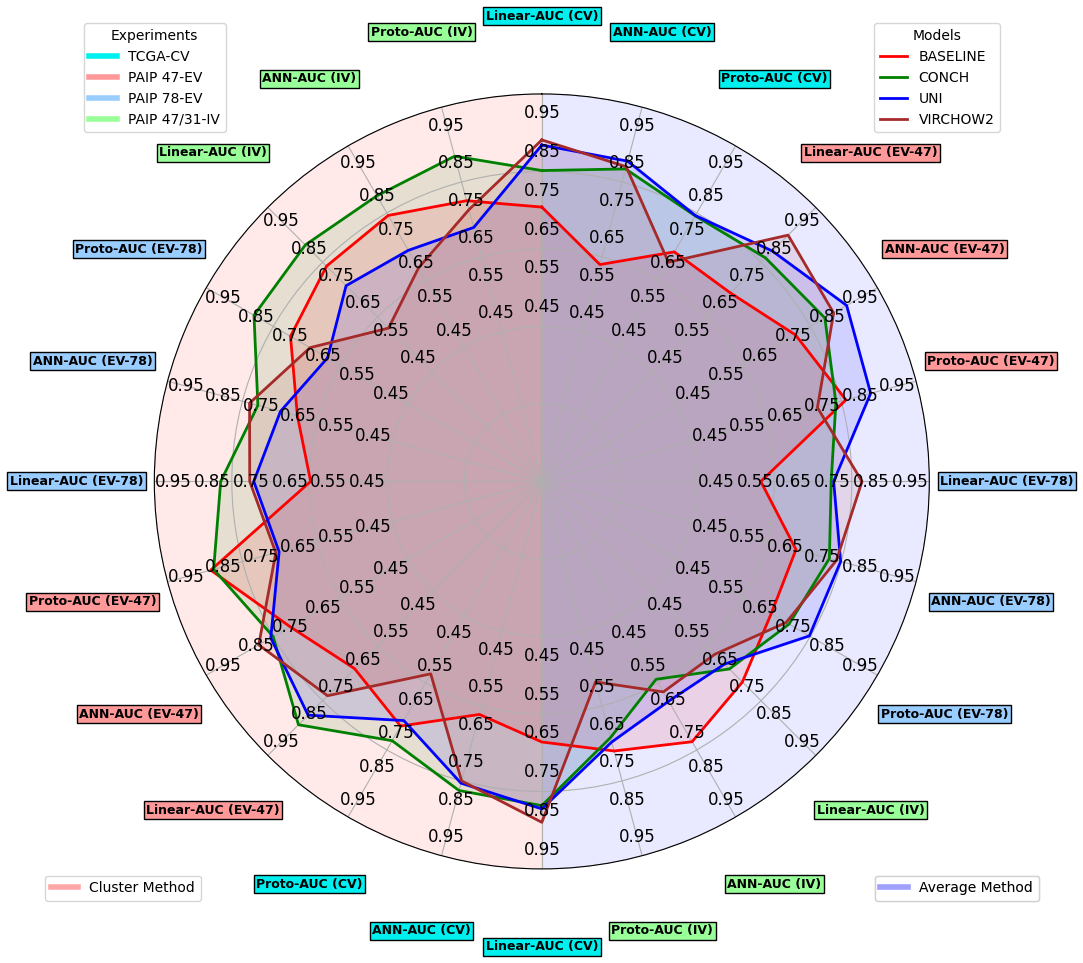

In [28]:
# Make balanced accuracy radar plot of 3 models (linear, ann, protonet) of all experiments in both approaches average and cluster method
# Define colors for different experiments
# ----------------------------
# 4) Plot each model
# ----------------------------
N = len(axis_labels)  
def close_circle(data_list):
    """Helper to 'close' the radar polygon."""
    return data_list + [data_list[0]]

# Define angles for radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # Close the radar

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)


# ----------------------------
# ADDED BACKGROUND FILL (0–180°, 180–360°)
# ----------------------------
theta_first = np.linspace(0, np.pi, 200)
r_first = np.ones_like(theta_first)
ax.fill(theta_first, r_first, color="#e0e0ff", alpha=0.7)

theta_second = np.linspace(np.pi, 2 * np.pi, 200)
r_second = np.ones_like(theta_second)
ax.fill(theta_second, r_second, color="#ffe0e0", alpha=0.7)

# Subplot adjustments to avoid label clipping
plt.subplots_adjust(top=0.85, bottom=0.05)

for (model_name, values), color in zip(models_data.items(), colors):
    stats = close_circle(values)
    # make a square outside each label name to make it more visible and readable
    ax.plot(angles, stats, color=color, label=model_name, linewidth=2)
    ax.fill(angles, stats, color=color, alpha=0.1)

# ----------------------------
# 5) Customize the radar chart to match desired settings
# ----------------------------
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)  # Make the angles go clockwise

# Add axis labels around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(axis_labels, fontsize=9, fontweight='bold')
# Modify label colors based on experiment group
for label, angle, group in zip(ax.get_xticklabels(), angles[:-1], experiment_groups):
    x, y = label.get_position()
    label.set_position((x, y - 0.15))
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    label.set_rotation(angle * 180 / np.pi)
    label.set_fontsize(9)
    label.set_fontweight('bold')
    # Set text box color based on experiment
    label.set_bbox(dict(facecolor=experiment_colors[group], edgecolor='black', boxstyle='square,pad=0.2')) 

# ----------------------------
# Add legend for experiments
# ----------------------------
experiment_legend = [
    plt.Line2D([0], [0], color=color, lw=4, label=exp)
    for exp, color in experiment_colors.items()
]
# Remove default radial tick labels but keep the radial grid
ax.set_yticklabels([])
ax.set_ylim(0.0, 1.0)  # Set range

# Define radial grid values manually (excluding the innermost circle)
r_ticks = np.arange(0.45, 1.0, 0.10)
for theta in angles[:-1]:
    for r in r_ticks:
        if r > 0.2:  # Skip the innermost circle
            ax.text(theta, r, f"{r:.2f}",
                    ha='center', va='center', fontsize=12,
                    color='black')

# First legend for experiments (Top-left)
exp_legend = ax.legend(handles=experiment_legend, loc="upper left", bbox_to_anchor=(-0.1, 1.1), title="Experiments")
ax.add_artist(exp_legend)  # Ensure this legend stays
# ----------------------------
# Add legend for models (top-right)
# ----------------------------
model_legend = ax.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1), title="Models")
ax.add_artist(model_legend)
# add two more bars like in the legend on the bottom left and right cornor to half represent the hald quadarnt write average method with it and for second write cluster method 
# Create custom legend handles for the half quadrants
half_quadrant_legend = [
    plt.Line2D([0], [0], color="#8080ff", lw=4, alpha=0.7, label="Average Method"),
    plt.Line2D([0], [0], color="#ff8080", lw=4, alpha=0.7, label=f"Cluster Method")
]

# Add legend for half quadrants (bottom-left)
half_quadrant_legend_left = ax.legend(
    handles=half_quadrant_legend[1:],  # Only the first handle (Average Method)
    loc="lower left", 
    bbox_to_anchor=(-0.15, -0.05), 
)
ax.add_artist(half_quadrant_legend_left)  # Ensure this legend stays

# Add legend for half quadrants (bottom-right)
half_quadrant_legend_right = ax.legend(
    handles=half_quadrant_legend[:1],  # Only the second handle (Cluster Method)
    loc="lower right", 
    bbox_to_anchor=(1.15, -0.05), 
)
ax.add_artist(half_quadrant_legend_right)  # Ensure this legend stays
# Title
# plt.title("3-Cluster Aggregation: (3) Classifier Models × (2) Metrics,For (4) Feature-Extraction Models", y=1.10)
# save the plot as a png file 
save_path = os.path.join(OUTPUT_DIR, f"Radar_Plots\\{EVAL_METRIC}_{AGG1}_{AGG2_DIR}_radar.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

### best results selection using table format from each experiment

In [ ]:
import pandas as pd
import os

def process_and_merge_files(input_files, output_file):
    """
    Process multiple Excel files, rename metrics with suffixes in the Metric column,
    and merge by sheet names while keeping the same column structure.
    
    Args:
        input_files: List of tuples containing (file_path, suffix)
        output_file: Path for the merged output Excel file
    """
    # Dictionary to hold all processed data by sheet name
    merged_data = {}
    
    # Process each input file
    for file_path, suffix in input_files:
        if not os.path.exists(file_path):
            print(f"⚠️ File not found: {file_path}")
            continue
            
        print(f"📖 Processing {file_path} with suffix '{suffix}'")
        
        # Read all sheets from the Excel file
        xls = pd.ExcelFile(file_path)
        
        for sheet_name in xls.sheet_names:
            # Read the sheet
            df = pd.read_excel(xls, sheet_name=sheet_name)
            
            # Add suffix to the Metric values (except the header row)
            df['Metric'] = df['Metric'].apply(
                lambda x: f"{x}_{suffix}" if not x.startswith('Metric') else x
            )
            
            # Add to our merged data dictionary
            if sheet_name not in merged_data:
                merged_data[sheet_name] = []
            merged_data[sheet_name].append(df)
    
    # Combine data for each sheet
    with pd.ExcelWriter(output_file) as writer:
        for sheet_name, dfs in merged_data.items():
            # Concatenate all DataFrames for this sheet vertically
            combined_df = pd.concat(dfs, axis=0, ignore_index=True)
            
            # Write to Excel
            combined_df.to_excel(
                writer, 
                sheet_name=sheet_name, 
                index=False
            )
            print(f"✏️ Saved merged data for sheet '{sheet_name}'")
    
    print(f"\n✅ Successfully created merged file at: {output_file}")

# Define your input files and their suffixes
input_files = [
    (f"{INPUT_DIR}/Averaging/all_exp_Averaging_metrics.xlsx", "avg"),
    (f"{INPUT_DIR}/Clustering/cluster_2/all_exp_cluster_2_metrics.xlsx", "c2"),
    (f"{INPUT_DIR}/Clustering/cluster_3/all_exp_cluster_3_metrics.xlsx", "c3")
]

# Output file path
output_file = f"{OUTPUT_DIR}/best_of_all_exps_metrics.xlsx"

# Run the processing
# process_and_merge_files(input_files, output_file)

📖 Processing E:\KSA Project\KSAproject_pipeline1\WSI_Classification/Averaging/all_exp_Averaging_metrics.xlsx with suffix 'avg'
📖 Processing E:\KSA Project\KSAproject_pipeline1\WSI_Classification/Clustering/cluster_2/all_exp_cluster_2_metrics.xlsx with suffix 'c2'
📖 Processing E:\KSA Project\KSAproject_pipeline1\WSI_Classification/Clustering/cluster_3/all_exp_cluster_3_metrics.xlsx with suffix 'c3'
✏️ Saved merged data for sheet 'PAIP-EV47'
✏️ Saved merged data for sheet 'PAIP-EV78'
✏️ Saved merged data for sheet 'PAIP-IV'
✏️ Saved merged data for sheet 'TCGA-CV'

✅ Successfully created merged file at: E:\KSA Project\KSAproject_pipeline1\Analysis_Visualization/best_of_all_exps_metrics.xlsx


### Select Top3 (BalAcc and AUC) scores from each experiment

In [3]:
import pandas as pd

def get_top_results(merged_file_path):
    # Read the merged Excel file
    xls = pd.ExcelFile(merged_file_path)
    
    # Dictionary to store top results for each sheet
    top_results = {}
    
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # Create lists to store top entries
        auroc_entries = []
        bacc_entries = []
        
        # Get all auroc and bacc rows (regardless of suffix)
        auroc_rows = df[df['Metric'].str.contains('auroc')]
        bacc_rows = df[df['Metric'].str.contains('bacc')]
        
        # Process each auroc row to find best model
        for _, row in auroc_rows.iterrows():
            models = ['baseline_N', 'uni_N', 'conch_N', 'virchow2_N']
            best_model = max(models, key=lambda x: row[x])
            auroc_entries.append({
                'metric': row['Metric'],
                'model': best_model,
                'score': row[best_model],
                'score_type': 'auroc'
            })
        
        # Process each bacc row to find best model
        for _, row in bacc_rows.iterrows():
            models = ['baseline_N', 'uni_N', 'conch_N', 'virchow2_N']
            best_model = max(models, key=lambda x: row[x])
            bacc_entries.append({
                'metric': row['Metric'],
                'model': best_model,
                'score': row[best_model],
                'score_type': 'bacc'
            })
        
        # Get top 3 for each score type
        top_auroc = pd.DataFrame(auroc_entries).nlargest(3, 'score')
        top_bacc = pd.DataFrame(bacc_entries).nlargest(3, 'score')
        
        # Combine results
        top_results[sheet_name] = pd.concat([top_auroc, top_bacc])
    
    return top_results

# Usage
merged_file = f"{OUTPUT_DIR}/best_of_all_exps_metrics.xlsx"
results = get_top_results(merged_file)

# Print results for each sheet
for sheet_name, df in results.items():
    print(f"\n🔬 Top results for {sheet_name}:")
    print(df.to_string(index=False))


🔬 Top results for PAIP-EV47:
       metric      model    score score_type
ann_auroc_avg      uni_N 0.908333      auroc
lin_auroc_avg virchow2_N 0.898810      auroc
 lin_auroc_c2    conch_N 0.888095      auroc
proto_bacc_c2    conch_N 0.778274       bacc
 ann_bacc_avg virchow2_N 0.775893       bacc
proto_bacc_c3    conch_N 0.751488       bacc

🔬 Top results for PAIP-EV78:
        metric      model    score score_type
proto_auroc_c2    conch_N 0.857716      auroc
proto_auroc_c3    conch_N 0.832516      auroc
  lin_auroc_c2    conch_N 0.828724      auroc
 proto_bacc_c2    conch_N 0.775424       bacc
 proto_bacc_c3    conch_N 0.739295       bacc
  ann_bacc_avg virchow2_N 0.726360       bacc

🔬 Top results for PAIP-IV:
        metric      model    score score_type
proto_auroc_c2    conch_N 0.869048      auroc
  lin_auroc_c2    conch_N 0.863095      auroc
  knn_auroc_c2    conch_N 0.863095      auroc
 proto_bacc_c2 baseline_N 0.836310       bacc
  lin_bacc_avg baseline_N 0.815476       bacc

### Select Top3 (from BalAcc or AUC) score from each experiment

In [14]:
import pandas as pd

def get_top_results(merged_file_path):
    # Read the merged Excel file
    xls = pd.ExcelFile(merged_file_path)
    
    # Dictionary to store top results for each sheet
    top_results = {}
    
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # Create list to store all scores with complementary info
        all_scores = []
        
        # Get all auroc and bacc rows
        auroc_rows = df[df['Metric'].str.contains('auroc')]
        bacc_rows = df[df['Metric'].str.contains('bacc')]
        
        # Process auroc metrics
        for _, row in auroc_rows.iterrows():
            models = ['baseline_N', 'uni_N', 'conch_N', 'virchow2_N']
            best_model = max(models, key=lambda x: row[x])
            
            # Extract prefix (ann, lin, etc.) and suffix (avg, c2, etc.)
            parts = row['Metric'].split('_')
            prefix = '_'.join(parts[:-2])  # handles cases like 'ann' or 'proto_net'
            suffix = parts[-1]
            
            # Find corresponding bacc score
            bacc_metric = f"{prefix}_bacc_{suffix}"
            bacc_score = None
            if bacc_metric in df['Metric'].values:
                bacc_score = df.loc[df['Metric'] == bacc_metric, best_model].values[0]
            
            all_scores.append({
                'primary_metric': row['Metric'],
                'primary_model': best_model,
                'primary_score': row[best_model],
                'primary_type': 'auroc',
                'complementary_metric': bacc_metric,
                'complementary_score': bacc_score
            })
        
        # Process bacc metrics
        for _, row in bacc_rows.iterrows():
            models = ['baseline_N', 'uni_N', 'conch_N', 'virchow2_N']
            best_model = max(models, key=lambda x: row[x])
            
            # Extract prefix and suffix
            parts = row['Metric'].split('_')
            prefix = '_'.join(parts[:-2])
            suffix = parts[-1]
            
            # Find corresponding auroc score
            auroc_metric = f"{prefix}_auroc_{suffix}"
            auroc_score = None
            if auroc_metric in df['Metric'].values:
                auroc_score = df.loc[df['Metric'] == auroc_metric, best_model].values[0]
            
            all_scores.append({
                'primary_metric': row['Metric'],
                'primary_model': best_model,
                'primary_score': row[best_model],
                'primary_type': 'bacc',
                'complementary_metric': auroc_metric,
                'complementary_score': auroc_score
            })
        
        # Convert to DataFrame and select top 3 scores overall
        scores_df = pd.DataFrame(all_scores)
        
        # Get top 3 regardless of score type
        top_results[sheet_name] = scores_df.nlargest(3, 'primary_score')
    
    return top_results

# Usage
merged_file = f"{OUTPUT_DIR}/best_of_all_exps_metrics.xlsx"
results = get_top_results(merged_file)

# Print results for each sheet
for sheet_name, df in results.items():
    print(f"\n🏆 Top 3 results for {sheet_name}:")
    print(df[['primary_metric', 'primary_model', 'primary_score', 'primary_type',
              'complementary_metric', 'complementary_score']].to_string(index=False))


🏆 Top 3 results for PAIP-EV47:
primary_metric primary_model  primary_score primary_type complementary_metric  complementary_score
 ann_auroc_avg         uni_N       0.908333        auroc         ann_bacc_avg             0.763988
 lin_auroc_avg    virchow2_N       0.898810        auroc         lin_bacc_avg             0.579762
  lin_auroc_c2       conch_N       0.888095        auroc          lin_bacc_c2             0.500000

🏆 Top 3 results for PAIP-EV78:
primary_metric primary_model  primary_score primary_type complementary_metric  complementary_score
proto_auroc_c2       conch_N       0.857716        auroc        proto_bacc_c2             0.775424
proto_auroc_c3       conch_N       0.832516        auroc        proto_bacc_c3             0.739295
  lin_auroc_c2       conch_N       0.828724        auroc          lin_bacc_c2             0.500000

🏆 Top 3 results for PAIP-IV:
primary_metric primary_model  primary_score primary_type complementary_metric  complementary_score
proto_auroc_c2 